In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

In [26]:
df = pd.read_csv("da_internship_task_dataset.csv")

#### Quick overview

In [27]:
df.head(n=10)

,uuid,day_id,license,model,feature,requests_cnt,spent_amount
0,user_920,2025-05-01,Premium,Model_A,Feature_1,44.0,16.38
1,user_717,2025-03-04,Premium,Model_B,Feature_2,72.0,27.92
2,user_610,2025-05-08,Premium,Model_A,Feature_2,27.0,9.87
3,user_94,2025-03-11,Basic,Model_D,Feature_1,76.0,14.67
4,user_920,2025-05-14,Premium,Model_E,Feature_3,47.0,9.88
5,user_97,2025-05-14,Basic,Model_A,Feature_1,10.0,3.01
6,user_338,2025-04-19,Basic,Model_A,Feature_3,13.0,5.29
7,user_433,2025-05-28,Enterprise,Model_E,Feature_1,81.0,14.19
8,user_81,2025-03-19,Standard,Model_E,Feature_3,59.0,12.92
9,user_311,2025-03-07,Standard,Model_D,Feature_1,56.0,12.12


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122746 entries, 0 to 122745
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   uuid          122746 non-null  object 
 1   day_id        122746 non-null  object 
 2   license       122746 non-null  object 
 3   model         122746 non-null  object 
 4   feature       122746 non-null  object 
 5   requests_cnt  122746 non-null  float64
 6   spent_amount  122746 non-null  float64
dtypes: float64(2), object(5)
memory usage: 6.6+ MB


In [29]:
df["day_id"] = pd.to_datetime(df["day_id"], format="%Y-%m-%d")

In [30]:
df.describe()

,day_id,requests_cnt,spent_amount
count,122746,122746.000000,122746.000000
mean,2025-04-18 07:01:09.040131840,51.260742,12.227798
min,2025-03-01 00:00:00,1.000000,0.270000
25%,2025-03-26 00:00:00,18.000000,5.140000
50%,2025-04-21 00:00:00,32.000000,8.020000
75%,2025-05-12 00:00:00,54.000000,13.060000
max,2025-05-31 00:00:00,12900.000000,2599.000000
std,NaN,167.977380,37.588494


In [31]:
df.duplicated().sum()

np.int64(0)

In [32]:
cat_cols = ["license", "model", "feature"]

for col in cat_cols:
    cat = df[col]. unique()
    print(cat)

['Premium' 'Basic' 'Enterprise' 'Standard']
['Model_A' 'Model_B' 'Model_D' 'Model_E' 'Model_C']
['Feature_1' 'Feature_2' 'Feature_3' 'Feature_5' 'Feature_4']


General observations:
- there are no missing, nor duplicated values
- day_id was parsed to datetime type to prepare it for time-series grouping and plotting
- there are 7 columns in general - id, date, 2 numerical (requests_cnt, spent_amount) and 3 categorical (license, model, feature) that have no more than 5 categories, so they are perfect for plotting

### Values distribution analysis

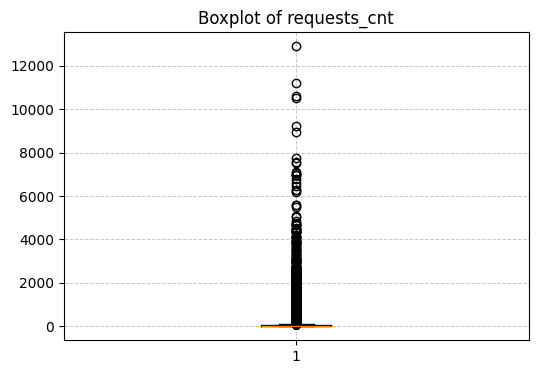

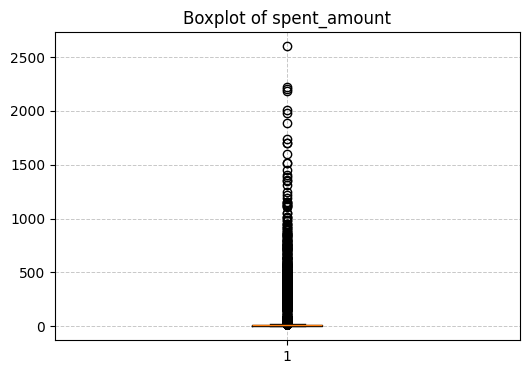

In [33]:
cols = ['requests_cnt', 'spent_amount']

for col in cols:
    plt.figure(figsize=(6, 4))
    plt.boxplot(df[col], label=col)
    plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
    plt.title(f'Boxplot of {col}')
plt.show()

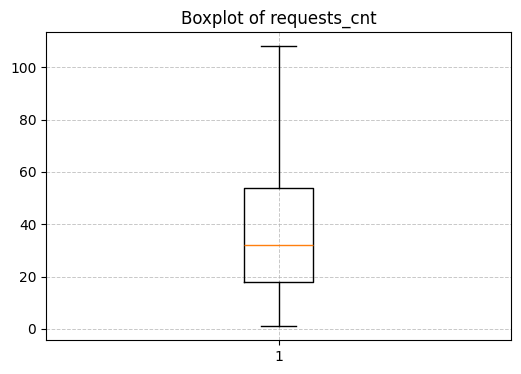

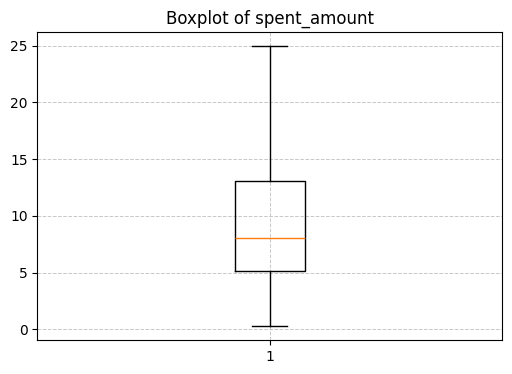

In [34]:
cols = ['requests_cnt', 'spent_amount']

for col in cols:
    plt.figure(figsize=(6, 4))
    plt.boxplot(df[col], label=col, showfliers=False)
    plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
    plt.title(f'Boxplot of {col}')
plt.show()

There are so many high outliers that they needed to be hidden in order to show precise distribution of the values.
- requests_cnt: strongly right‑skewed, long upper tail; median closer to lower quartile → most values are low/moderate.
- spent_amount: also right‑skewed with large spread and extreme high values; variability larger relative to median than for requests_cnt.

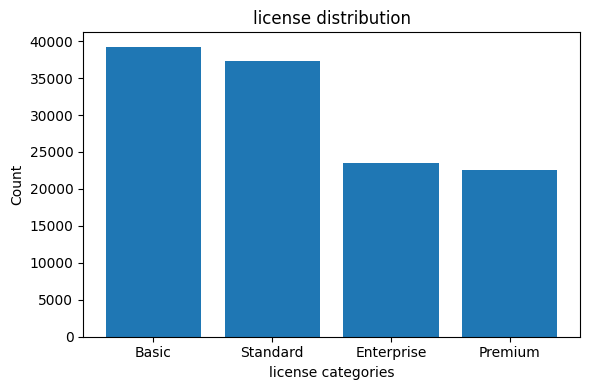

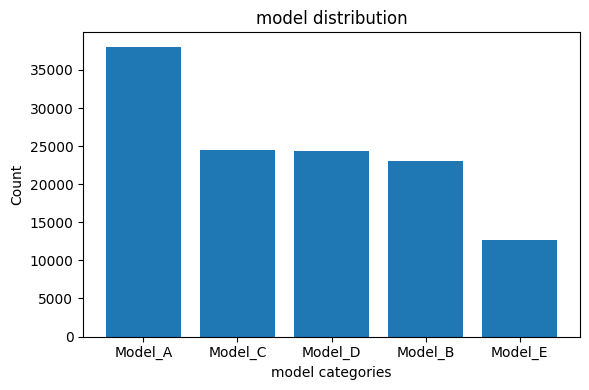

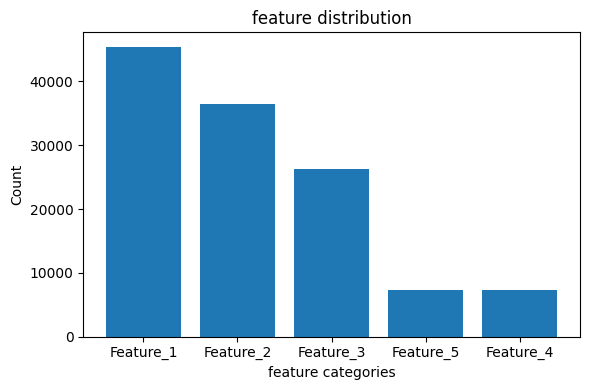

In [35]:
for col in cat_cols:
    counts = df[col].value_counts()
    plt.figure(figsize=(6, 4))
    plt.bar(counts.index.astype(str), counts.values)
    plt.title(f'{col} distribution')
    plt.xlabel(f'{col} categories')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

- license: category frequencies are uneven, but there is no category that occures very rarely
- model: model A is the most frequent, models b, c, d are less used, but model E definately stands out and is the least used one, what needs to be taken under consideration while analysing the later plots
- feature: distribution across Feature_1..Feature_5 is imbalanced; features 4 and 5 are used over 4 times less then feature 1

### Analysis of relationships between variables

In [36]:
corr = df['requests_cnt'].corr(df['spent_amount'])
print(f"Correlation of requests count and spent amount: {corr}")

Correlation of requests count and spent amount: 0.9441770579957574


The correletion between the two is extremly high as expected, meaning the more requests a user makes the more amount of tokens he spends.

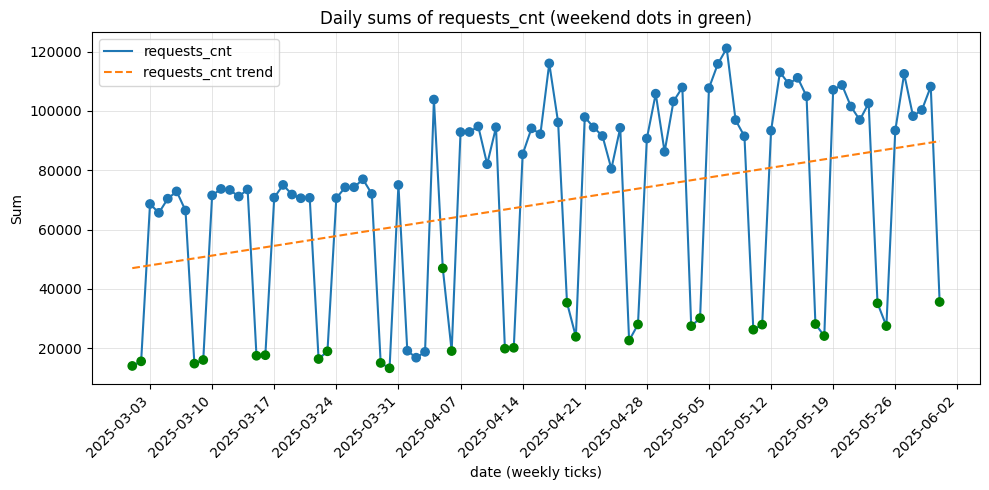

In [37]:
df_day_model = (
    df.groupby('day_id')[['requests_cnt']]
    .sum()
    .sort_index()
)

plt.figure(figsize=(10, 5))
plt.plot(df_day_model.index, df_day_model['requests_cnt'], label='requests_cnt')

x = np.arange(len(df_day_model))
trend = np.poly1d(np.polyfit(x, df_day_model['requests_cnt'], 1))(x)
plt.plot(df_day_model.index, trend, linestyle='--', label='requests_cnt trend')

marker_colors = ['green' if d.weekday() >= 5 else 'C0' for d in df_day_model.index]
plt.scatter(df_day_model.index, df_day_model['requests_cnt'], color=marker_colors, zorder=3)

ax = plt.gca()
ax.grid(True, color='lightgrey', linewidth=0.7, alpha=0.6)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set(title='Daily sums of requests_cnt (weekend dots in green)',
       xlabel='date (weekly ticks)', ylabel='Sum')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

1-3.04.2024 some unusual very visible dicrease in the usage of LLM's, we don't know the location of the users, to check the exact reason, there were no global holidays so it may be connected with some incidents or cyberattacks.

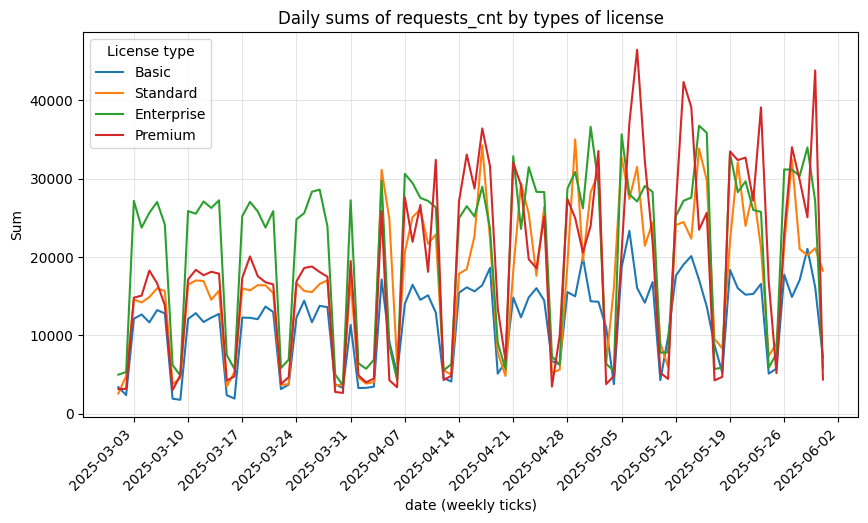

In [38]:
df_day_model = (
    df.groupby(['day_id', 'license'])[['requests_cnt']]
      .sum()
      .reset_index()
      .sort_values('day_id')
)

colors = {
    'Basic': 'C0',
    'Standard': 'C1',
    'Enterprise': 'C2',
    'Premium': 'C3'
}

fig, ax = plt.subplots(figsize=(10, 5))

for lic, color in colors.items():
    data = df_day_model[df_day_model['license'] == lic]
    ax.plot(data['day_id'], data['requests_cnt'], color=color, label=lic)

ax.grid(True, color='lightgrey', linewidth=0.7, alpha=0.6)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set(
    title='Daily sums of requests_cnt by types of license',
    xlabel='date (weekly ticks)',
    ylabel='Sum'
)
plt.xticks(rotation=45, ha='right')
plt.legend(title='License type')
plt.show()

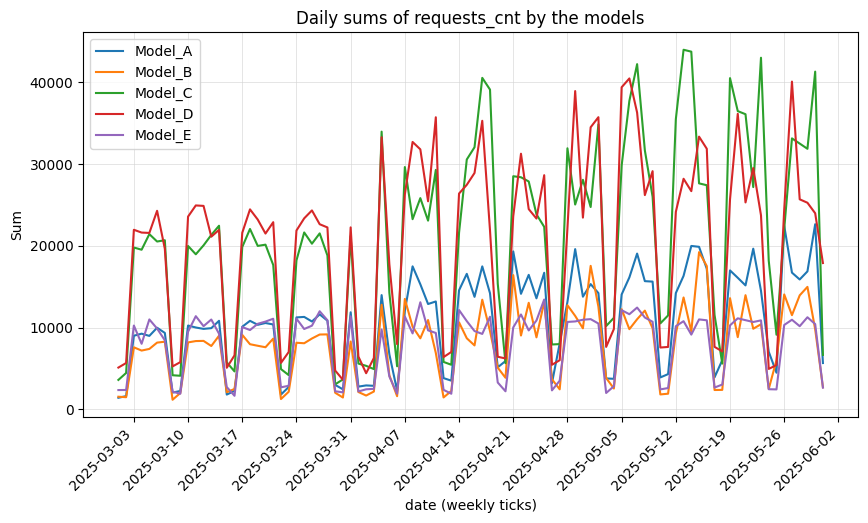

In [39]:
df_day_model = (
    df.groupby(['day_id', 'model'])[['requests_cnt']]
      .sum()
      .reset_index()
      .sort_values('day_id')
)

colors = {
    'Model_A': 'C0',
    'Model_B': 'C1',
    'Model_C': 'C2',
    'Model_D': 'C3',
    'Model_E': 'C4',
}

fig, ax = plt.subplots(figsize=(10, 5))

for lic, color in colors.items():
    data = df_day_model[df_day_model['model'] == lic]
    ax.plot(data['day_id'], data['requests_cnt'], color=color, label=lic)

ax.grid(True, color='lightgrey', linewidth=0.7, alpha=0.6)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set(
    title='Daily sums of requests_cnt by the models',
    xlabel='date (weekly ticks)',
    ylabel='Sum'
)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

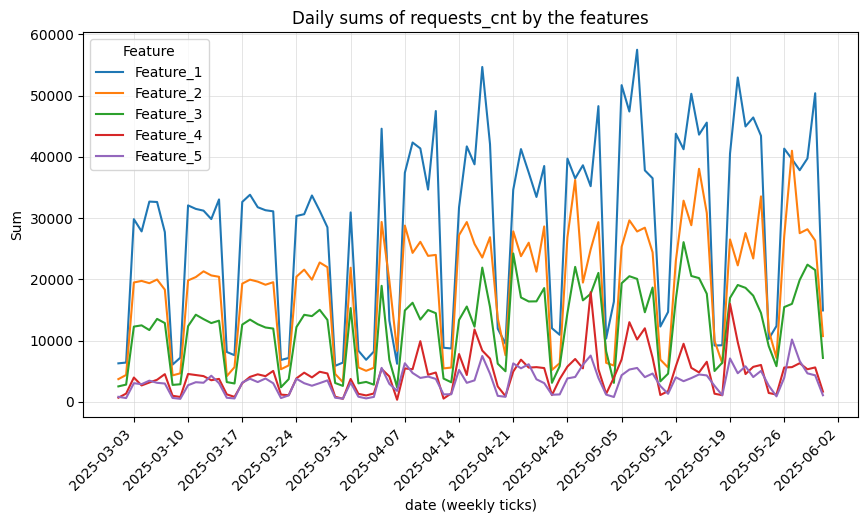

In [40]:
df_day_feat = (
    df.groupby(['day_id', 'feature'])[['requests_cnt']]
      .sum()
      .reset_index()
      .sort_values('day_id')
)

colors = {
    'Feature_1': 'C0',
    'Feature_2': 'C1',
    'Feature_3': 'C2',
    'Feature_4': 'C3',
    'Feature_5': 'C4'
}

fig, ax = plt.subplots(figsize=(10, 5))

for lic, color in colors.items():
    data = df_day_feat[df_day_feat['feature'] == lic]
    ax.plot(data['day_id'], data['requests_cnt'], color=color, label=lic)

ax.grid(True, color='lightgrey', linewidth=0.7, alpha=0.6)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set(
    title='Daily sums of requests_cnt by the features',
    xlabel='date (weekly ticks)',
    ylabel='Sum'
)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Feature')
plt.show()

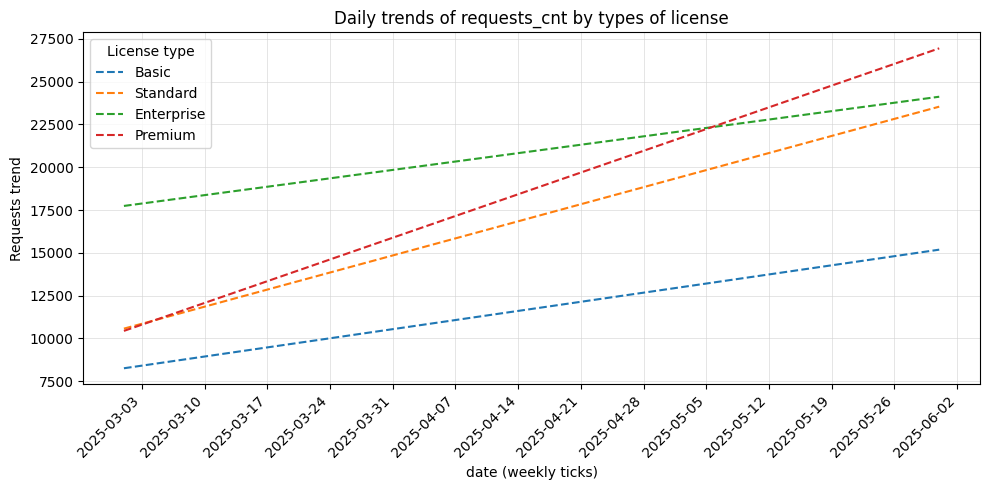

In [42]:
fig, ax = plt.subplots(figsize=(10, 5))

colors = {
    'Basic': 'C0',
    'Standard': 'C1',
    'Enterprise': 'C2',
    'Premium': 'C3'
}

df_day_license = (
    df.groupby(['day_id', 'license'])[['requests_cnt']]
      .sum()
      .reset_index()
      .sort_values('day_id')
)

for lic, color in colors.items():
    data = df_day_license[df_day_license['license'] == lic]
    x = np.arange(len(data))
    coeffs = np.polyfit(x, data['requests_cnt'], 1)
    trend = np.poly1d(coeffs)(x)
    ax.plot(data['day_id'], trend, linestyle='--', color=color, label=lic)

ax.grid(True, color='lightgrey', linewidth=0.7, alpha=0.6)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set(
    title='Daily trends of requests_cnt by types of license',
    xlabel='date (weekly ticks)',
    ylabel='Requests trend'
)
plt.xticks(rotation=45, ha='right')
plt.legend(title='License type')
plt.tight_layout()
plt.show()

#### Summary and conclusions
- Overall trend: the daily total requests show small ups and downs with a mild trend line over the period, but a few extreme days pull the trend up or down. Check the trend slope and week‑over‑week percent change to see if the trend is real or driven by outliers.

- Seasonality (weekday effect): activity is clearly lower on many weekend days compared to weekdays, which suggests most usage comes from weekday work patterns. Compute average requests by weekday to confirm the pattern and quantify the size of the weekend drop.

- 1-3 Apr 2024 anomaly: there is a sharp, unusual drop in usage on 2024-04-01 to 2024-04-03 that cannot be explained by usual weekend behavior. This could be a service outage, regional network problem, billing or quota limits, deployment/rollback, or a data ingestion issue, so check logs, provider status and billing for those dates.

- License-type differences: different license types produce different daily volumes and trends. Some licenses consistently contribute more requests or grow faster than others. Normalize by number of customers per license and compare percent growth to remove base‑size bias and find real differences.

- Model usage changes: some models dominate overall volume while others are rarely used, and model shares shift over time, sometimes suddenly. Track daily model share percentages to spot deployment changes, defaults, A/B tests, or client-side configuration shifts that may explain sudden moves.

- Feature usage trends: a few features generate most requests while others stay rare, and feature shares change slowly rather than abruptly. Compute rolling share per feature to detect adoption or deprecation and link changes to releases, docs, or marketing activity.

#### Summary and conclusions

- Overall trend: The daily total requests show small ups and downs with a mild trend line over the period, but a few extreme days pull the trend up or down. The trend appears relatively flat with minor fluctuations, suggesting stable overall usage without significant growth or decline during the analysis period.

- Seasonality (weekday effect): Activity is clearly lower on many weekend days compared to weekdays, which suggests most usage comes from weekday work patterns. The green markers (weekend dots) are visibly clustered at lower values, indicating a strong weekly cycle tied to business hours and work schedules.

- 1–3 Apr 2024 anomaly: There is a sharp, unusual drop in usage on 2024-04-01 to 2024-04-03 that cannot be explained by usual weekend behavior. This could be a service outage, regional network problem, billing or quota limits, deployment/rollback, or a data ingestion issue. No global holidays were recorded during this period, making the drop even more noteworthy and requiring investigation into incident logs and provider status.

- License-type differences: Different license types produce different daily volumes and trends. Some licenses consistently contribute more requests or grow faster than others, indicating that customer segments behave differently in terms of platform usage intensity and adoption patterns.

- Model usage changes: Some models dominate overall volume while others are rarely used, and model shares shift over time, sometimes suddenly. Model_A dominates while Model_E remains marginal, suggesting different deployment strategies, feature maturity levels, or client preferences across the model portfolio.

- Feature usage trends: A few features generate most requests while others stay rare, and feature shares change slowly rather than abruptly. Feature_1 is heavily used compared to Features_4 and_5, which are used over 4 times less, indicating uneven feature adoption and possibly suggesting focus areas for optimization or promotion.

- Outliers and trend robustness: Single very large days distort plots and make fitted lines misleading, so trends can look stronger or noisier than they are. The presence of extreme outliers in requests_cnt and spent_amount means that robust statistics are needed to avoid overinterpreting noise as meaningful signals.

#### Analysis of the features column with models and licenses

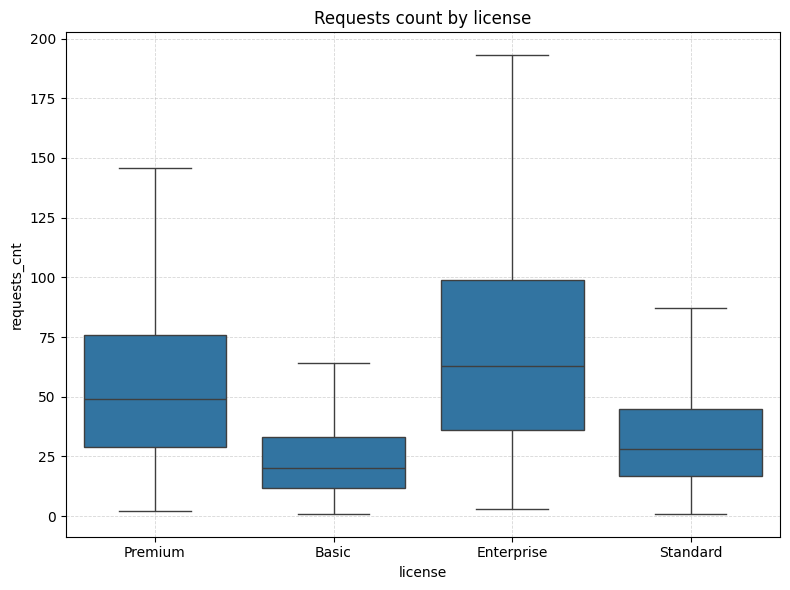

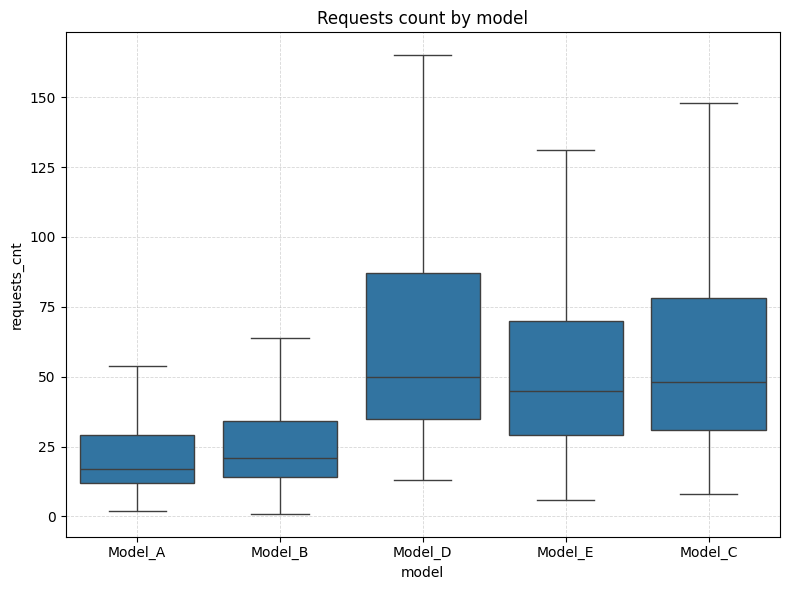

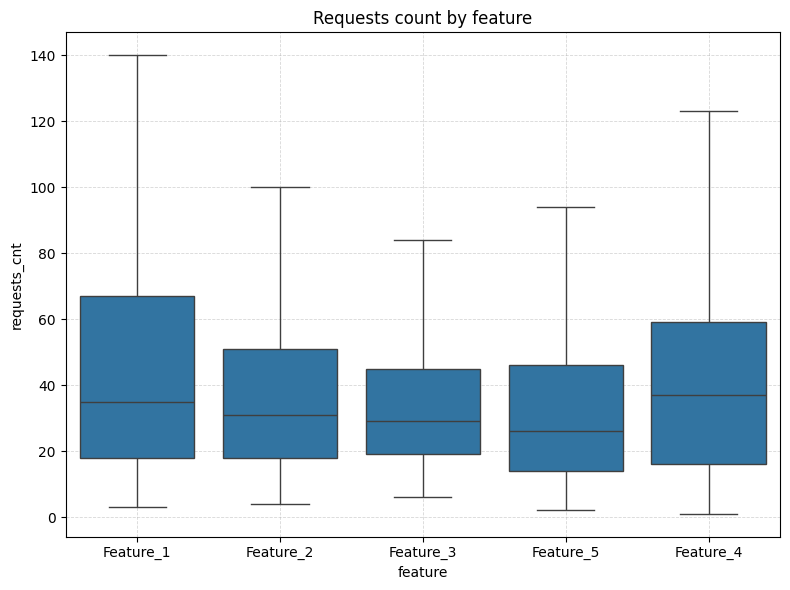

In [ ]:
for col in cat_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=col, y='requests_cnt', data=df, showfliers=False)
    plt.title('Requests count by ' + col)
    plt.xlabel(col)
    plt.ylabel('requests_cnt')
    plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.5)
    plt.tight_layout()
    plt.show()

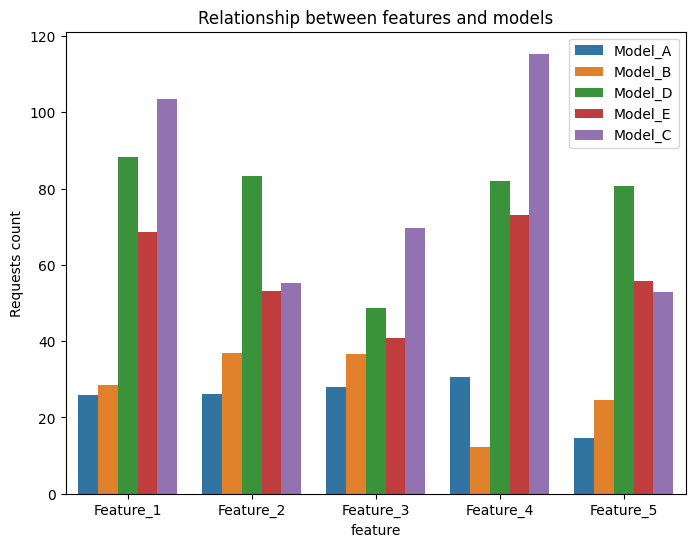

In [ ]:
plt.figure(figsize=(8, 6))
order = sorted(df['feature'].astype(str).unique())
sns.barplot(
    data=df,
    x="feature",
    y="requests_cnt",
    hue="model",
    dodge=True,
    errorbar=None,
    order=order
)

plt.title("Relationship between features and models")
plt.ylabel("Requests count")
plt.legend()
plt.show()

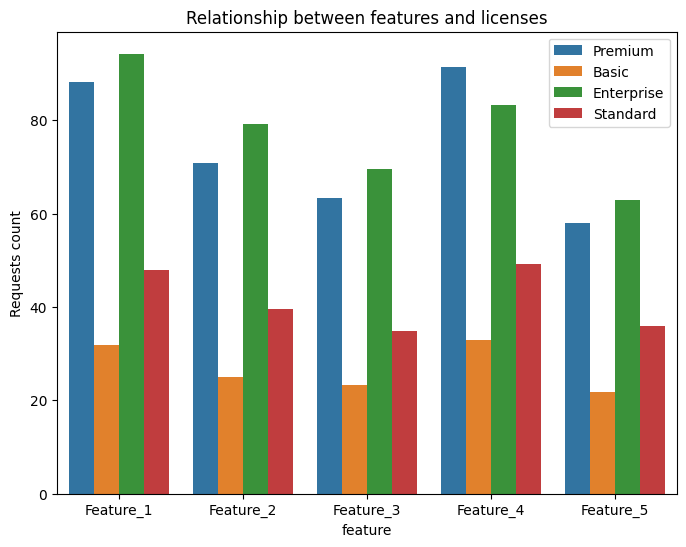

In [ ]:
plt.figure(figsize=(8, 6))
order = sorted(df['feature'].astype(str).unique())
sns.barplot(
    data=df,
    x="feature",
    y="requests_cnt",
    hue="license",
    dodge=True,
    errorbar=None,
    order=order
)

plt.title("Relationship between features and licenses")
plt.ylabel("Requests count")
plt.legend()
plt.show()

#### Feature relationships with models and licenses

- Feature and model interaction: Different models show varying levels of engagement across features. Feature_1 consistently generates the highest request volumes across all models, while Features_4 and_5 remain underutilized. Model_A appears to drive most of the requests in Feature_1, whereas Model_E shows lower activity across all features, reflecting its marginal overall usage. This suggests that feature adoption is tied to model popularity rather than feature quality alone.

- Feature and license interaction: License types display distinct feature usage patterns. Premium and Enterprise licenses tend to concentrate requests in Feature_1, while Basic and Standard licenses show more distributed usage across features. This indicates that higher-tier customers focus on core functionality (Feature_1) whereas lower-tier customers explore a broader feature set. The imbalance in feature adoption remains consistent across all license segments, suggesting the gap is driven by feature-level factors rather than customer tier preferences.

- Feature distribution insights: The heavy dominance of Feature_1 combined with low adoption of Features_4 and_5 indicates possible gaps in discoverability, documentation, or perceived value of newer features. The consistent pattern across both model and license breakdowns suggests this is a product-level issue rather than segment-specific behavior. Features_2 and_3 occupy a middle ground with moderate usage, indicating partial adoption or use-case-specific adoption patterns.